---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [30]:
import pandas as pd
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


class Work:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.encoder_dict = {}
        self.train_df = None
        self.test_df = None
        self.train_target = None
        self.addr_df = pd.read_csv('addresses.csv', encoding='latin1', low_memory=False)
        self.latlon_df = pd.read_csv('latlons.csv', encoding='latin1', low_memory=False)
        self.load_train_test_data()

        
    def print(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)

    def read_csv_data(self, f):
        df = pd.read_csv(f, encoding='latin1', low_memory=False)

        # only consider data where compliance is not null, no need to train the model with the data where user is not responsible.    

        if 'compliance' in df:
            df = df[df.compliance.notnull()]
        
        #convert zip_code to str
        #df['zip_code'] = df.zip_code.apply(str)
        
        self.print('Converting hearing/issue date interval')
        
        ns_per_day = 24 * 3600 * 1000 * 1000 * 1000
        td = pd.to_datetime(df.hearing_date) - pd.to_datetime(df.ticket_issued_date)
        df['days_to_hearing'] = td.astype(np.int64) // ns_per_day
        
        df = pd.merge(df, self.addr_df, on='ticket_id')
        df = pd.merge(df, self.latlon_df, on='address')

        
        for c in ['days_to_hearing', 'lat', 'lon']:
            if c in df:
                df[c] = df[c].fillna(df[c].median())
        
        # grafitti_status included in violation description
        # violation_description is not needed, violation_code closely reflects this feature
        # clean_up_cost was zero
        # violation_zip_code was all nulls in train data
        cols_to_drop = ['hearing_date', 'ticket_issued_date', 'grafitti_status', 'violation_description', 'clean_up_cost',
                       'violation_zip_code', 'violation_street_number', 'violation_street_name',
                       'non_us_str_code', 'country', 'mailing_address_str_number', 'mailing_address_str_name', 'address']
        
        
        #cols_to_drop += ['admin_fee', 'state_fee', 'late_fee', 'discount_amount']
        cols_to_drop += ['inspector_name', 'violator_name', 'city', 'state', 'zip_code', 'disposition', 'agency_name', 'violation_code']
        
        df.drop(cols_to_drop, axis=1, inplace=True)
        return df
    

    
    def encode_column(self, col):
        self.print ('Encoding col: ', col)
        le = LabelEncoder()
        
        for df in [self.train_df, self.test_df]:
            df[col] = df[col].fillna('_UNK')
            df[col] = df[col].str.upper()
        
        le.fit(np.r_[self.train_df[col].unique(), self.test_df[col].unique()])
        self.test_df[col] = le.transform(self.test_df[col])
        self.train_df[col] = le.transform(self.train_df[col])
        self.encoder_dict[col] = le
        
    def load_train_test_data(self):
        self.print('Loading Data')
        # this is the data we use to return answer
        self.test_df = self.read_csv_data('test.csv')        
        self.train_df = self.read_csv_data('train.csv')

        self.train_target = self.train_df.compliance
        
        # only use columns availbale in test data for features 
        self.train_df = self.train_df[self.test_df.columns]
        
        # convert categorical columns to numbers
        for col in [col for col, dt in self.train_df.dtypes.iteritems() if str(dt) == 'object']:
            self.encode_column(col)
        
        # convert 
        #for c in ('disposition', 'agency_name'):            
        #    self.train_df.join(pd.get_dummies(df[c], prefix=c)).drop(c,axis=1)
        #    self.test_df.join(pd.get_dummies(df[c], prefix=c)).drop(c,axis=1)

        
        self.print('Done loading Data')
        
    def get_anwser(self, clf, scaler=None):
        X_solve = self.test_df.iloc[:, 1:]
        if scaler:
            X_solve = scaler.transform(X_solve)
        y_proba = clf.predict_proba(X_solve)
        answer = pd.Series(y_proba[:,1], index=self.test_df.ticket_id, dtype='float32')
        return answer
    
    def plot_roc(self, clf, X_test, y_test):
        t = clf.__class__.__name__
        if hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(X_test)
        else:
            y_score = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        accuracy = clf.score(X_test, y_test)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(12,10))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
        plt.xlabel('FPR', fontsize=16)
        plt.ylabel('TPR', fontsize=16)
        plt.title(t + ' ROC curve (Accuracy: {:.3f})'.format(accuracy), fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()



    
def blight_model():
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import MinMaxScaler

    w = Work()
    
    X = w.train_df.iloc[:, 1:]
    y = w.train_target
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    mm_scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = mm_scaler.transform(X_train)
    X_test_scaled = mm_scaler.transform(X_test)

    clf = LogisticRegression(C=10, random_state=0)
    clf.fit(X_train_scaled, y_train)
    #w.plot_roc(clf, X_test_scaled, y_test)
    ans = w.get_anwser(clf, mm_scaler)
    
    return ans

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
w = Work()
X = w.train_df.iloc[:, 1:]
y = w.train_target

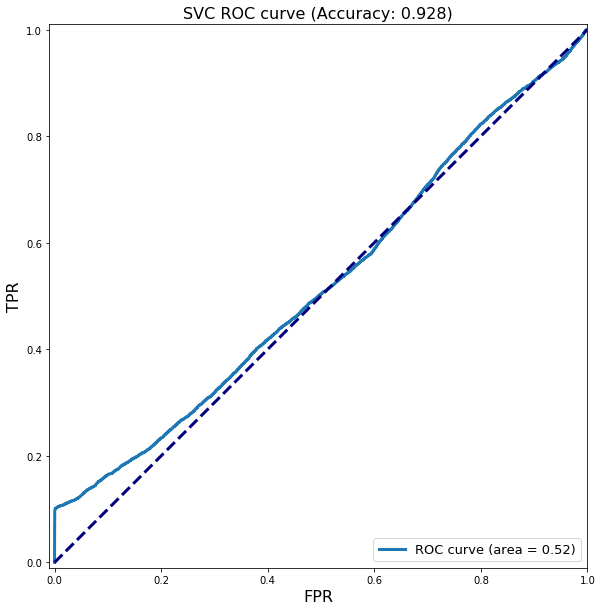

In [7]:
# SVM with small training size, scaling
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
# use N samples in training set
n_train = 10000
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, random_state=0)

mm_scaler = MinMaxScaler().fit(X)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

clf = SVC(kernel='rbf', gamma=.1)
clf.fit(X_train_scaled, y_train)
w.plot_roc(clf, X_test_scaled, y_test)


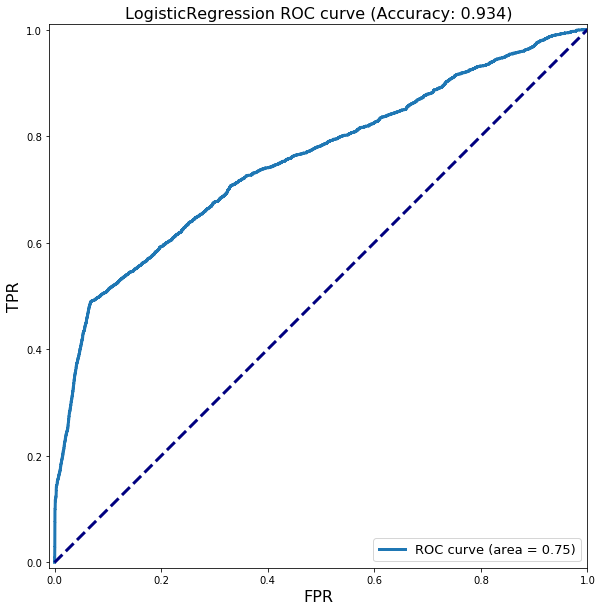

In [11]:
# default logisticregression with regularization
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LogisticRegression(C=.1, random_state=0)
clf.fit(X_train, y_train)
w.plot_roc(clf, X_test, y_test)

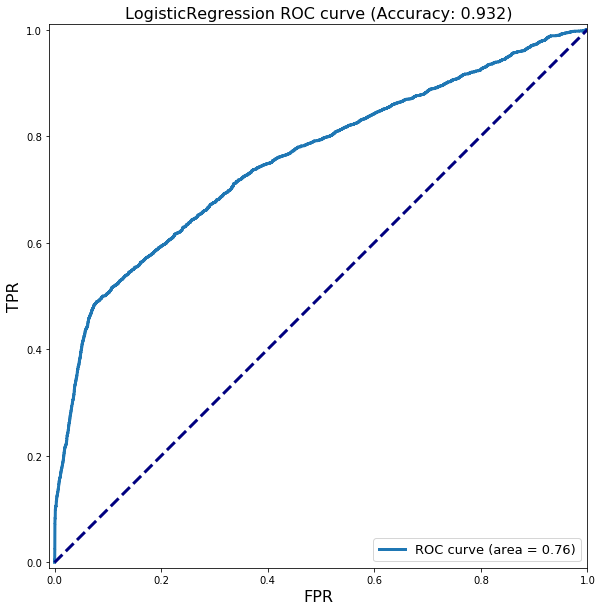

In [12]:
# default logisticregression with regularization and feature scaling
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

mm_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

clf = LogisticRegression(C=10, random_state=0)
clf.fit(X_train_scaled, y_train)
w.plot_roc(clf, X_test_scaled, y_test)


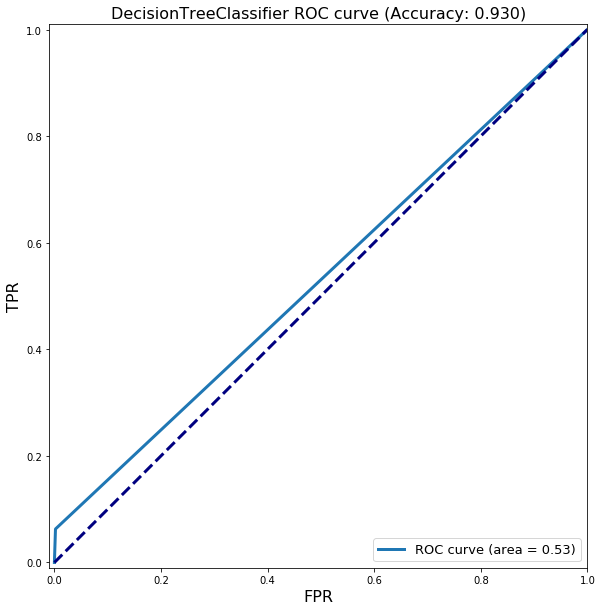

In [49]:
# decision tree 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)
w.plot_roc(clf, X_test, y_test)



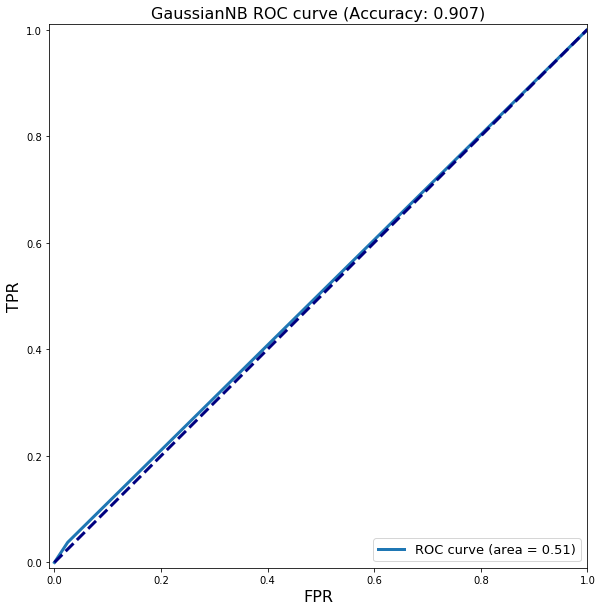

In [50]:
# Gaussian NB 

from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


clf = GaussianNB()
clf.fit(X_train, y_train)
w.plot_roc(clf, X_test, y_test)

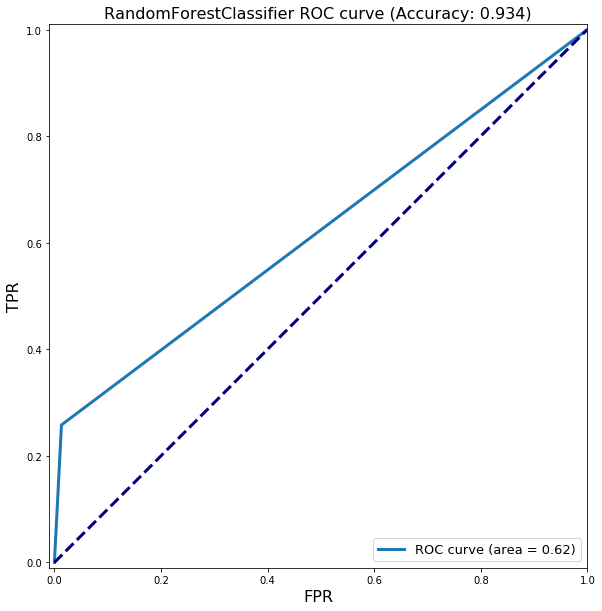

In [51]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


clf = RandomForestClassifier() #max_depth=3) #, n_estimators=5) #, max_features=2)
clf.fit(X_train, y_train)
w.plot_roc(clf, X_test, y_test)

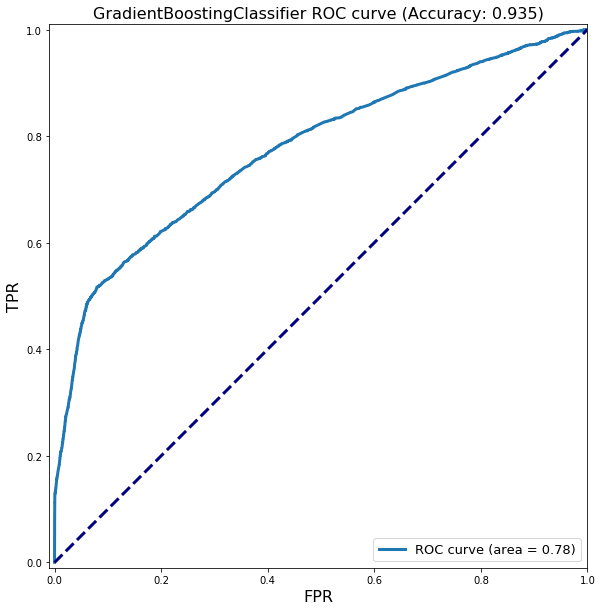

In [31]:
# GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier
w = Work()

X = w.train_df.iloc[:, 1:]
y = w.train_target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train, y_train)
w.plot_roc(clf, X_test, y_test)


In [32]:
list(zip(X_train.columns, clf.feature_importances_))

[('fine_amount', 0.059999999999999998),
 ('admin_fee', 0.0),
 ('state_fee', 0.0),
 ('late_fee', 0.14999999999999999),
 ('discount_amount', 0.029999999999999999),
 ('judgment_amount', 0.080000000000000002),
 ('days_to_hearing', 0.16),
 ('lat', 0.20999999999999999),
 ('lon', 0.31)]

[('fine_amount', 0.02),
 ('admin_fee', 0.0),
 ('state_fee', 0.0),
 ('late_fee', 0.14999999999999999),
 ('discount_amount', 0.029999999999999999),
 ('judgment_amount', 0.14999999999999999),
 ('lat', 0.25),
 ('lon', 0.40000000000000002)]

In [19]:
train_df = pd.read_csv('train.csv', encoding='latin1', low_memory=False)

In [20]:
train_df.shape

(250306, 34)

In [21]:
train_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [23]:
df = train_df
td = (pd.to_datetime(df.hearing_date) - pd.to_datetime(df.ticket_issued_date))

0            369
1            378
2            336
3        -106752
4            336
5            323
6            253
7            251
8            251
9            323
10           222
11           221
12           209
13           201
14           189
15           186
16           183
17           266
18           138
19           138
20           138
21           190
22           189
23           215
24           100
25            96
26            40
27            50
28            24
29            50
           ...  
250276        29
250277        29
250278        37
250279        29
250280        29
250281        30
250282        30
250283         9
250284        25
250285        49
250286        49
250287        10
250288        26
250289        10
250290        40
250291        49
250292         5
250293         5
250294        25
250295        17
250296      3722
250297      3722
250298      1495
250299      1495
250300      1495
250301      1495
250302      1495
250303      14